In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

In [206]:
def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, bw=np.array([0.2]),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(kernel='exponential',bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


kde_funcs = [kde_statsmodels_u, kde_scipy, kde_sklearn, kde_statsmodels_m]
kde_funcnames = ['Statsmodels-U', 'Scipy', 'Scikit-learn', 'Statsmodels-M']

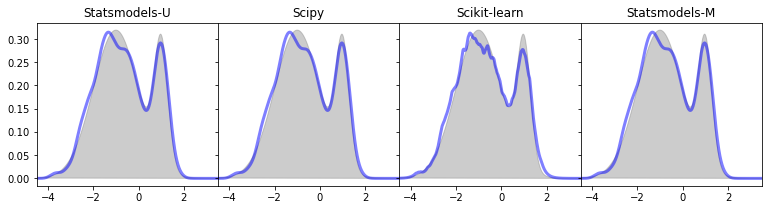

In [207]:
from scipy.stats.distributions import norm

# The grid we'll use for plotting
x_grid = np.linspace(-4.5, 3.5, 1000)

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
x = np.concatenate([norm(-1, 1.).rvs(400),
                    norm(1, 0.3).rvs(100)])
pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) +
            0.2 * norm(1, 0.3).pdf(x_grid))

# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 4, sharey=True,
                       figsize=(13, 3))
fig.subplots_adjust(wspace=0)

for i in range(4):
    pdf = kde_funcs[i](x, x_grid, bandwidth=0.2)
    ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
    ax[i].fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4)
    ax[i].set_title(kde_funcnames[i])
    ax[i].set_xlim(-4.5, 3.5)

## Now load pickle files and compute their density functions

In [74]:
cd velocity_distribution

D:\GitHub\Clone\planning\ruixuan\velocity_distribution


In [78]:
with open('pedestrian_2Hz.pkl', 'rb') as f:
    pedestrian_data = pickle.load(f)

In [82]:
# compute the density function
def compute_density(frequency_data, step_size=0.1):
    total = frequency_data.sum()
    density = frequency_data/total/step_size
    
    return density

In [87]:
pedestrian_density = compute_density(pedestrian_data['full'])

In [218]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.0001, 1.0, 30)},
                    cv=20) # 30-fold cross-validation
grid.fit(np.concatenate([[0],pedestrian_density[1:20]])[:, None])
print(grid.best_params_)

{'bandwidth': 0.03457931034482759}


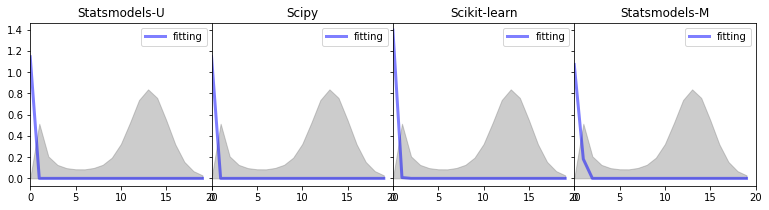

In [219]:
# The grid we'll use for plotting
x_grid = np.linspace(0, 99, 100)

# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 4, sharey=True,
                       figsize=(13, 3))
fig.subplots_adjust(wspace=0)

for i in range(4):
    pdf = kde_funcs[i](np.concatenate([[0],pedestrian_density[1:20]]), x_grid[0:20], bandwidth=0.03457931034482759)
    ax[i].plot(x_grid[0:20], pdf, color='blue', alpha=0.5, lw=3,label='fitting')
    ax[i].fill_between(x_grid[0:20], np.concatenate([[0],pedestrian_density[1:20]]), ec='gray', fc='gray', alpha=0.4)
    ax[i].legend(fontsize = 10)
    ax[i].set_title(kde_funcnames[i])
    ax[i].set_xlim(0, 20)

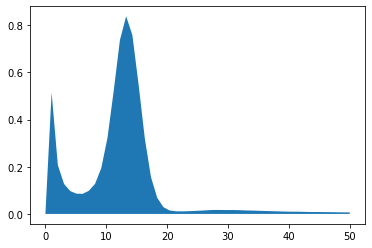

In [212]:
plt.fill_between(np.linspace(0, 50, 50),np.concatenate([[0],pedestrian_density[1:50]]),label='true',linestyle='-.')